# Training for SIFT

Build a training pipeline using the validation dataset first; then extend to the train and test set (as the train set is very large...)

Proposed pipeline

Baseline  
DoG (keypoint selection) + SIFT (feature extraction) -> KMean + SVM classifier (good at high-dimensional stuff)

Features
- hyperparemter search on these hyperparameters (like keypoint-threshold, K for KMean)
- cross-validation (maybe 5-fold), with different random seed
- tackling class-imbalance. Such as using imbalanced-learn to under-sampling the human class; and over-sampling the remaining class to achieve roughly-balanced dataset
- or see: https://arxiv.org/pdf/2403.07113 for image-based augmentation

Advanced/improvements
- A hard-code threshold to filter less confident keypoints
- Include dimension-reduction (like UMAP, or PCA) techniques before KMean
- Other clustering methods? like HDBSCAN (some features will be classified as -1, as they become outliers)
- Ensemble learning? Like SVM + RF/GradBoost + Naive Bayes (but previous results shows linear SVM already okay; or kernel SVM?
)

In [1]:
from pycocotools.coco import COCO
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import cv2

In [2]:
data_type = 'val2017'
ann_file = 'dataset/coco/annotations/instances_{}.json'.format(data_type)

coco = COCO(ann_file)

loading annotations into memory...
Done (t=0.31s)
creating index...
index created!


In [3]:
# all categories (with ids)
cats = coco.loadCats(coco.getCatIds())

# load data
img_ids = [coco.dataset['images'][i]['id'] for i in range(len(coco.dataset['images']))]
img_ids_w_filename = {coco.dataset['images'][i]['id']: coco.dataset['images'][i]['file_name'] for i in range(len(coco.dataset['images']))}      # use dictionary for faster query
annotations = coco.loadAnns(coco.getAnnIds(imgIds=img_ids))

In [4]:
# load labels for each imgs (as one img may have multiple labels)
labels_per_imgs = []
for i in range(len(img_ids)):
    labels_per_imgs.append(coco.loadAnns(coco.getAnnIds(imgIds=img_ids[i])))

In [5]:
# now we create the real list of datasets

img_id_w_bb = []
label_per_obj = []

for labels in labels_per_imgs:
    for l in labels:
        img_id_w_bb.append((l['id'], l['image_id'], l['bbox']))
        label_per_obj.append(l['category_id'])

In [6]:
img_id_w_bb

[(82445, 397133, [217.62, 240.54, 38.99, 57.75]),
 (119568, 397133, [1.0, 240.24, 346.63, 186.76]),
 (200887, 397133, [388.66, 69.92, 109.41, 277.62]),
 (693231, 397133, [135.57, 249.43, 22.32, 28.79]),
 (713388, 397133, [31.28, 344.0, 68.12, 40.83]),
 (716434, 397133, [59.63, 287.36, 76.07, 41.3]),
 (1125079, 397133, [1.36, 164.33, 192.56, 98.37]),
 (1218137, 397133, [0.0, 262.81, 62.16, 36.77]),
 (1878837, 397133, [119.4, 272.51, 24.82, 34.25]),
 (1883614, 397133, [141.47, 267.91, 32.19, 35.86]),
 (1902250, 397133, [155.97, 168.95, 26.03, 17.13]),
 (1902971, 397133, [157.2, 114.15, 17.86, 15.82]),
 (1914453, 397133, [98.75, 304.78, 10.78, 5.57]),
 (2105658, 397133, [166.03, 256.36, 8.82, 18.58]),
 (2114911, 397133, [86.41, 293.97, 23.96, 11.18]),
 (2114949, 397133, [70.14, 296.16, 9.28, 4.58]),
 (2139366, 397133, [0.0, 210.9, 191.36, 98.98]),
 (2188144, 397133, [96.69, 297.09, 7.84, 4.86]),
 (2196309, 397133, [497.25, 203.4, 122.01, 28.61]),
 (22328, 37777, [102.49, 118.47, 7.9, 17.3

In [7]:
label_per_obj

[44,
 67,
 1,
 49,
 51,
 51,
 79,
 1,
 47,
 47,
 51,
 51,
 56,
 50,
 56,
 56,
 79,
 57,
 81,
 64,
 62,
 62,
 67,
 82,
 52,
 79,
 81,
 55,
 55,
 55,
 55,
 62,
 55,
 1,
 1,
 1,
 28,
 31,
 47,
 10,
 2,
 1,
 1,
 1,
 1,
 1,
 1,
 2,
 41,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 2,
 3,
 3,
 10,
 10,
 3,
 3,
 3,
 8,
 8,
 8,
 10,
 70,
 81,
 70,
 4,
 4,
 1,
 1,
 1,
 1,
 1,
 1,
 4,
 4,
 4,
 1,
 1,
 70,
 70,
 70,
 70,
 70,
 70,
 70,
 70,
 70,
 70,
 70,
 81,
 3,
 3,
 3,
 4,
 4,
 1,
 1,
 1,
 1,
 1,
 1,
 2,
 8,
 16,
 16,
 1,
 1,
 1,
 1,
 4,
 16,
 16,
 1,
 1,
 3,
 1,
 1,
 76,
 84,
 84,
 84,
 84,
 84,
 84,
 84,
 84,
 84,
 84,
 84,
 62,
 72,
 84,
 84,
 84,
 64,
 64,
 86,
 86,
 72,
 62,
 84,
 84,
 84,
 84,
 84,
 84,
 84,
 84,
 84,
 63,
 51,
 55,
 55,
 55,
 51,
 55,
 55,
 1,
 5,
 1,
 5,
 33,
 16,
 25,
 21,
 64,
 9,
 9,
 9,
 1,
 9,
 9,
 9,
 9,
 15,
 9,
 1,
 9,
 9,
 20,
 20,
 20,
 20,
 1,
 1,
 1,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 3,
 3,
 3,
 3,
 3,
 3,
 6,
 1,
 1,
 3,
 3,
 3,
 3,
 3,
 1,
 1,
 6,
 1,
 6,

Create train-test split

In [8]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(img_id_w_bb, label_per_obj, test_size=0.2, random_state=42)

In [9]:
X_train

[(2200577, 561958, [203.21, 206.04, 24.1, 83.3]),
 (1234599, 208363, [528.43, 110.91, 87.51, 109.27]),
 (454570, 256775, [380.57, 313.77, 34.23, 98.68]),
 (1181286, 191845, [10.03, 158.27, 17.89, 32.9]),
 (1803061, 172935, [124.93, 262.44, 132.12, 26.06]),
 (100906, 186980, [45.42, 287.66, 196.82, 344.08]),
 (1317738, 210394, [454.7, 229.43, 9.17, 18.84]),
 (25758, 31735, [544.72, 188.61, 56.61, 75.76]),
 (1507874, 492878, [188.53, 244.23, 95.68, 153.09]),
 (1435276, 38048, [276.35, 207.36, 8.63, 18.25]),
 (1798643, 293324, [301.7, 305.91, 14.81, 21.09]),
 (1464177, 450439, [18.17, 155.82, 137.1, 60.01]),
 (1660393, 31248, [81.99, 161.88, 5.91, 26.66]),
 (560922, 247917, [307.79, 199.92, 51.78, 112.93]),
 (1898153, 91654, [34.73, 0.0, 602.79, 460.27]),
 (1584166, 422836, [154.67, 163.5, 8.2, 21.39]),
 (357416, 376284, [209.88, 28.09, 61.94, 31.86]),
 (1414647, 311295, [245.11, 179.76, 46.51, 59.62]),
 (1655724, 421923, [185.34, 207.15, 115.07, 14.91]),
 (528558, 274708, [338.04, 199.23

create pipeline

gray-scale -> SIFT detector

(inside the "process_image_with_sift" function)

In [10]:
# using HuggingFace datasets to optimize memory usage

from pathlib import Path
from datasets import Dataset

# 1. First, prepare your data for the datasets library
def prepare_dataset_dict(X, img_ids_w_filename):
    # Create a lightweight dictionary containing only metadata (not images)
    dataset_dict = {
        "image_id": [],
        "bbox": [],
        "file_name": []
    }
    
    for sample in X:
        dataset_dict["image_id"].append(sample[1])
        dataset_dict["bbox"].append(sample[2])
        dataset_dict["file_name"].append(img_ids_w_filename[sample[1]])
        
    return dataset_dict

# 2. Define the SIFT processing function

def process_image_with_sift(example):
    """Process a single image, extracting SIFT features"""
    # Load image only when needed
    img_path = Path(f"dataset/coco/val2017/{example['file_name']}")
    img = cv2.imread(str(img_path))
    
    # Apply bounding box
    x, y, w, h = example['bbox']
    img_cropped = img[int(y): int(y + h) + 1, int(x):int(x + w) + 1]
    
    # Convert to grayscale
    img_gray = cv2.cvtColor(img_cropped, cv2.COLOR_BGR2GRAY)
    
    # Apply SIFT
    sift = cv2.SIFT_create()
    keypoints, descriptors = sift.detectAndCompute(img_gray, None)
    
    # Convert keypoints to serializable format
    serialized_keypoints = []
    for kp in keypoints:
        serialized_keypoints.append({
            'x': float(kp.pt[0]),
            'y': float(kp.pt[1]), 
            'size': float(kp.size),
            'angle': float(kp.angle),
            'response': float(kp.response),
            'octave': int(kp.octave)
        })
    
    # Return only the features, together with the image_id, bbox, and filename
    # but not the image (pixel) itself
    return {
        'image_id': example['image_id'],
        'bbox': example['bbox'],
        'file_name': example['file_name'],
        'keypoints': serialized_keypoints,
        'descriptors': descriptors.tolist() if descriptors is not None else []
    }

# 3. Main pipeline
def create_sift_dataset(X_train, img_ids_w_filename):
    # Create the dataset dictionary
    dataset_dict = prepare_dataset_dict(X_train, img_ids_w_filename)
    
    # Create HF dataset
    raw_dataset = Dataset.from_dict(dataset_dict)
    
    # Process using (optional) multi-processing
    processed_dataset = raw_dataset.map(
        process_image_with_sift,
        num_proc=1,
        batched=False,
        desc="Extracting SIFT features"
    )
    
    return processed_dataset


/Users/michaelcheng/miniforge3/envs/comp61342_asm/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [11]:
sift_dataset_training = create_sift_dataset(X_train, img_ids_w_filename)

Extracting SIFT features: 100%|██████████| 29424/29424 [03:46<00:00, 130.13 examples/s]


In [12]:
len(sift_dataset_training)

29424

In [13]:
sift_dataset_training[0]

{'image_id': 561958,
 'bbox': [203.21, 206.04, 24.1, 83.3],
 'file_name': '000000561958.jpg',
 'keypoints': [{'angle': 45.48919677734375,
   'octave': 6882303,
   'response': 0.020551029592752457,
   'size': 3.134206771850586,
   'x': 3.9260289669036865,
   'y': 23.838598251342773},
  {'angle': 103.7919921875,
   'octave': 12845567,
   'response': 0.04137100651860237,
   'size': 2.1448497772216797,
   'x': 5.66931676864624,
   'y': 78.18323516845703},
  {'angle': 257.2601013183594,
   'octave': 12845567,
   'response': 0.04137100651860237,
   'size': 2.1448497772216797,
   'x': 5.66931676864624,
   'y': 78.18323516845703},
  {'angle': 29.1243896484375,
   'octave': 6423296,
   'response': 0.01408716756850481,
   'size': 6.229495525360107,
   'x': 6.978196620941162,
   'y': 47.19277572631836},
  {'angle': 321.76837158203125,
   'octave': 6423296,
   'response': 0.01408716756850481,
   'size': 6.229495525360107,
   'x': 6.978196620941162,
   'y': 47.19277572631836},
  {'angle': 163.77429

In [14]:
# get all keypoints and descriptors
all_keypoints = []
all_descriptors = []
for example in sift_dataset_training:
    all_keypoints.extend(example['keypoints'])
    all_descriptors.extend(example['descriptors'])
len(all_keypoints), len(all_descriptors)
# convert to numpy array
all_keypoints_np = np.array(all_keypoints)
all_descriptors_np = np.array(all_descriptors)

In [15]:
all_keypoints_np[0]

{'angle': 45.48919677734375,
 'octave': 6882303,
 'response': 0.020551029592752457,
 'size': 3.134206771850586,
 'x': 3.9260289669036865,
 'y': 23.838598251342773}

In [16]:
all_descriptors_np[0]

array([  2.,  23.,  61.,  46.,  88.,  41.,   9.,   2.,   5.,   2.,   2.,
         7.,  47.,  25.,  17.,  20.,   7.,   2.,   0.,   0.,   0.,  27.,
        86.,  46.,  10.,  16.,   6.,   0.,   1.,  52.,  45.,   4.,   0.,
        10.,  60.,  14.,   7.,   2.,   0.,   1.,  64.,  13.,  25.,   8.,
         7.,   7.,   7.,  28., 139.,  43.,   1.,   0.,   0.,  33., 112.,
       139.,  16.,  19.,   2.,   0.,   0., 139., 139.,  26.,   0.,   1.,
         2.,   0.,   0.,   0.,   0.,   2.,  41.,   8.,   3.,   0.,   0.,
         0.,   6.,  47., 139., 139.,  40.,   4.,   0.,   2.,   7.,  32.,
        14., 139., 109.,   1.,   0.,  92.,  51.,   6.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,
         1.,   5.,   2.,  26.,  35.,  33.,   0.,   0.,   0.,   4.,   1.,
       139., 116.,   9.,   0.,   0.,   0.,   0.])

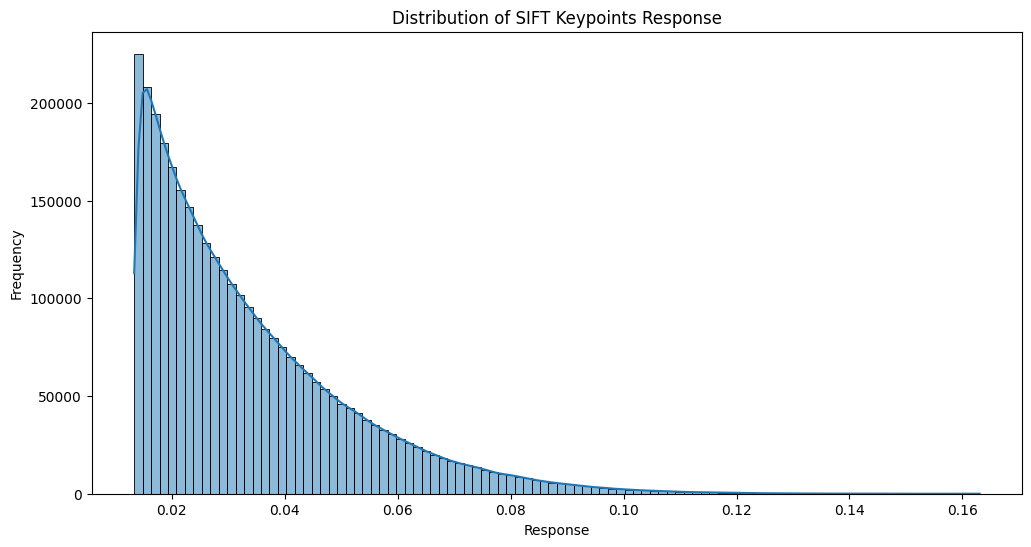

In [17]:
# TODO: go through all keypoints and get a pandas table of the distribution of the response of the keypoints

# then plot the distribution of the response
# and also the quartiles

import pandas as pd
import seaborn as sns

# Convert to DataFrame
keypoints_df_dict = {
    'x': [kp['x'] for kp in all_keypoints_np],
    'y': [kp['y'] for kp in all_keypoints_np],
    'size': [kp['size'] for kp in all_keypoints_np],
    'angle': [kp['angle'] for kp in all_keypoints_np],
    'response': [kp['response'] for kp in all_keypoints_np],
    'octave': [kp['octave'] for kp in all_keypoints_np],
}
keypoints_df = pd.DataFrame.from_dict(keypoints_df_dict)
# Plot the distribution of the response
plt.figure(figsize=(12, 6))
sns.histplot(keypoints_df['response'], bins=100, kde=True)
plt.title('Distribution of SIFT Keypoints Response')
plt.xlabel('Response')
plt.ylabel('Frequency')
plt.show()

In [18]:
# compute the quartiles with pandas
q10 = keypoints_df['response'].quantile(0.1)
q25 = keypoints_df['response'].quantile(0.25)
q50 = keypoints_df['response'].quantile(0.5)
q75 = keypoints_df['response'].quantile(0.75)
q90 = keypoints_df['response'].quantile(0.9)
q95 = keypoints_df['response'].quantile(0.95)

q10, q25, q50, q75, q90, q95

(np.float64(0.01561904139816761),
 np.float64(0.01960773579776287),
 np.float64(0.02851969003677368),
 np.float64(0.04265642911195755),
 np.float64(0.05912115052342415),
 np.float64(0.07029604911804199))

In [20]:
# filter the dataset to only keep keypoints and descriptors with response > threshold (let say 0.02)
# TODO: lift up the threshold such that we can reduce the number of keypoints by 50% or more
# actually we may not need to filter...


def filter_keypoints(example, threshold=0.02):
    """Filter keypoints based on respons
    and also whether the descriptor is not empty"""
    filtered_keypoints = []
    filtered_descriptors = []
    for kp, des in zip(example['keypoints'], example['descriptors']):
        if kp['response'] > threshold and len(des) > 0:
            filtered_keypoints.append(kp)
            filtered_descriptors.append(des)
    
    # Update the example with the filtered keypoints
    # note that the resulting keypoints and descriptors may be empty
    # if no keypoints pass the filter
    example['keypoints'] = filtered_keypoints
    example['descriptors'] = filtered_descriptors

    return example

filter_threshold = -1

if filter_threshold > 0:
    # Apply the filter to the dataset
    sift_dataset_training_filtered = sift_dataset_training.map(
        filter_keypoints,
        # fn_kwargs={'threshold': keypoints_df['response'].quantile(0.5)},        # use 50th percentile as threshold
        fn_kwargs={'threshold': -1},        # no filtering
        num_proc=1,
        desc="Filtering keypoints based on response"
)
else:
    # no filtering
    sift_dataset_training_filtered = sift_dataset_training

In [21]:
# count number of keypoints and descriptors
num_keypoints = 0
num_descriptors = 0

for example in sift_dataset_training_filtered:
    num_keypoints += len(example['keypoints'])
    num_descriptors += len(example['descriptors'])

print(f"Total number of keypoints: {num_keypoints}")
print(f"Total number of descriptors: {num_descriptors}")

Total number of keypoints: 3359381
Total number of descriptors: 3359381


In [22]:
# get all keypoints and descriptors
all_keypoints = []
all_descriptors = []
for example in sift_dataset_training_filtered:
    all_keypoints.extend(example['keypoints'])
    all_descriptors.extend(example['descriptors'])
len(all_keypoints), len(all_descriptors)
# convert to numpy array
all_keypoints_np = np.array(all_keypoints)
all_descriptors_np = np.array(all_descriptors)

Model

K-mean -> SVM

In [23]:
from sklearn.cluster import KMeans

K = 200     # number of clusters = number of visual words
kmeans = KMeans(n_clusters=K, random_state=42)
kmeans.fit(all_descriptors_np)

kmean_cluster_centers = kmeans.cluster_centers_


In [24]:
# extend the dataset with the cluster id
def assign_cluster_id(example, kmeans):
    """Assign cluster id to each keypoint based on the closest cluster center"""
    # Update the example with the cluster ids

    des = np.array(example['descriptors'])

    # early return if no descriptors
    if des.size == 0:
        example['cluster_ids'] = np.array([], dtype=np.int32)
        return example

    if des.ndim == 1:
        example['cluster_ids'] = kmeans.predict(des.reshape(1, -1))
    else:
        example['cluster_ids'] = kmeans.predict(des)
    
    return example

# Apply the filter to the dataset
sift_dataset_training_filtered = sift_dataset_training_filtered.map(
    assign_cluster_id,
    fn_kwargs={'kmeans': kmeans},
    num_proc=1,
    desc="Assigning cluster ids to keypoints"
)

Assigning cluster ids to keypoints: 100%|██████████| 29424/29424 [04:14<00:00, 115.82 examples/s]


In [25]:
# create a histogram of the cluster ids
# that will be used to compute TF-IDF

def create_histogram(example):
    """Create a histogram of cluster ids"""

    # early exit if descriptors are empty -> cluster_ids will be empty too
    if len(example['descriptors']) == 0:
        example['histogram'] = np.array([[]], dtype=np.int64)
        return example
    

    hist, _ = np.histogram(example['cluster_ids'], bins=np.arange(K + 1))
    
    example['histogram'] = hist.reshape(-1, K)

    return example

# Apply the histogram function to the dataset
sift_dataset_training_filtered = sift_dataset_training_filtered.map(
    create_histogram,
    num_proc=1,
    desc="Creating histogram of cluster ids"
)

Creating histogram of cluster ids: 100%|██████████| 29424/29424 [03:53<00:00, 125.86 examples/s]


In [26]:
# create histogram using TF-IDF
from sklearn.feature_extraction.text import TfidfTransformer

# convert the des_kmeans to a count-matrix
# then use TfidfVectorizer to convert it to a TF-IDF matrix
tfidf_transformer = TfidfTransformer()

# grab all non-empty histograms and concat them to a very large 2D array
des_histo = np.concatenate(
    [example['histogram'] for example in sift_dataset_training_filtered if len(example['histogram'][0]) > 0],
    axis=0
)

# Convert the list of descriptors to TF-IDF representation
tfidf_matrix = tfidf_transformer.fit_transform(des_histo)

In [27]:
# note that we drop some of the images in the y_train set
# because they have no descriptors
# so we need to filter the y_train set too

y_train_filtered = [y_train[i] for i, example in enumerate(sift_dataset_training_filtered) if len(example['histogram'][0]) > 0]
y_train_filtered = np.array(y_train_filtered)

In [28]:
# SVM

from sklearn.svm import SVC

svm = SVC(random_state=42)
svm.fit(tfidf_matrix, y_train_filtered)

SVC(random_state=42)

Test against the test set

In [29]:
sift_dataset_testing = create_sift_dataset(X_test, img_ids_w_filename)
sift_dataset_testing_filtered = sift_dataset_testing.map(
    filter_keypoints,
    fn_kwargs={'threshold': -1},        # no filtering
    num_proc=1,
    desc="Filtering keypoints based on response"
)
sift_dataset_testing_filtered = sift_dataset_testing_filtered.map(
    assign_cluster_id,
    fn_kwargs={'kmeans': kmeans},
    num_proc=1,
    desc="Assigning cluster ids to keypoints"
)
sift_dataset_testing_filtered = sift_dataset_testing_filtered.map(
    create_histogram,
    num_proc=1,
    desc="Creating histogram of cluster ids"
)

Creating histogram of cluster ids: 100%|██████████| 7357/7357 [00:57<00:00, 127.26 examples/s]


In [30]:
# transform with TF-IDF

# grab all non-empty histograms and concat them to a very large 2D array
des_histo_test = np.concatenate(
    [example['histogram'] for example in sift_dataset_testing_filtered if len(example['histogram'][0]) > 0],
    axis=0
)
# Convert the list of descriptors to TF-IDF representation
tfidf_matrix_test = tfidf_transformer.transform(des_histo_test)

In [31]:
y_test_filtered = [y_test[i] for i, example in enumerate(sift_dataset_testing_filtered) if len(example['histogram'][0]) > 0]
y_test_filtered = np.array(y_test_filtered)

In [32]:
# predict

y_pred = svm.predict(tfidf_matrix_test)

Evaluation

In [33]:
from sklearn.metrics import classification_report, confusion_matrix

target_names = [d['name'] for d in cats]
print(classification_report(y_test_filtered, y_pred, target_names=target_names, zero_division=0))

                precision    recall  f1-score   support

        person       0.32      0.99      0.48      2034
       bicycle       0.00      0.00      0.00        52
           car       0.20      0.01      0.02       347
    motorcycle       0.00      0.00      0.00        80
      airplane       0.00      0.00      0.00        31
           bus       0.45      0.16      0.24        63
         train       0.28      0.18      0.22        28
         truck       0.00      0.00      0.00        80
          boat       0.00      0.00      0.00        71
 traffic light       0.00      0.00      0.00        94
  fire hydrant       0.00      0.00      0.00        12
     stop sign       1.00      0.31      0.47        13
 parking meter       0.00      0.00      0.00         4
         bench       1.00      0.01      0.03        76
          bird       0.00      0.00      0.00        60
           cat       0.00      0.00      0.00        33
           dog       0.00      0.00      0.00  

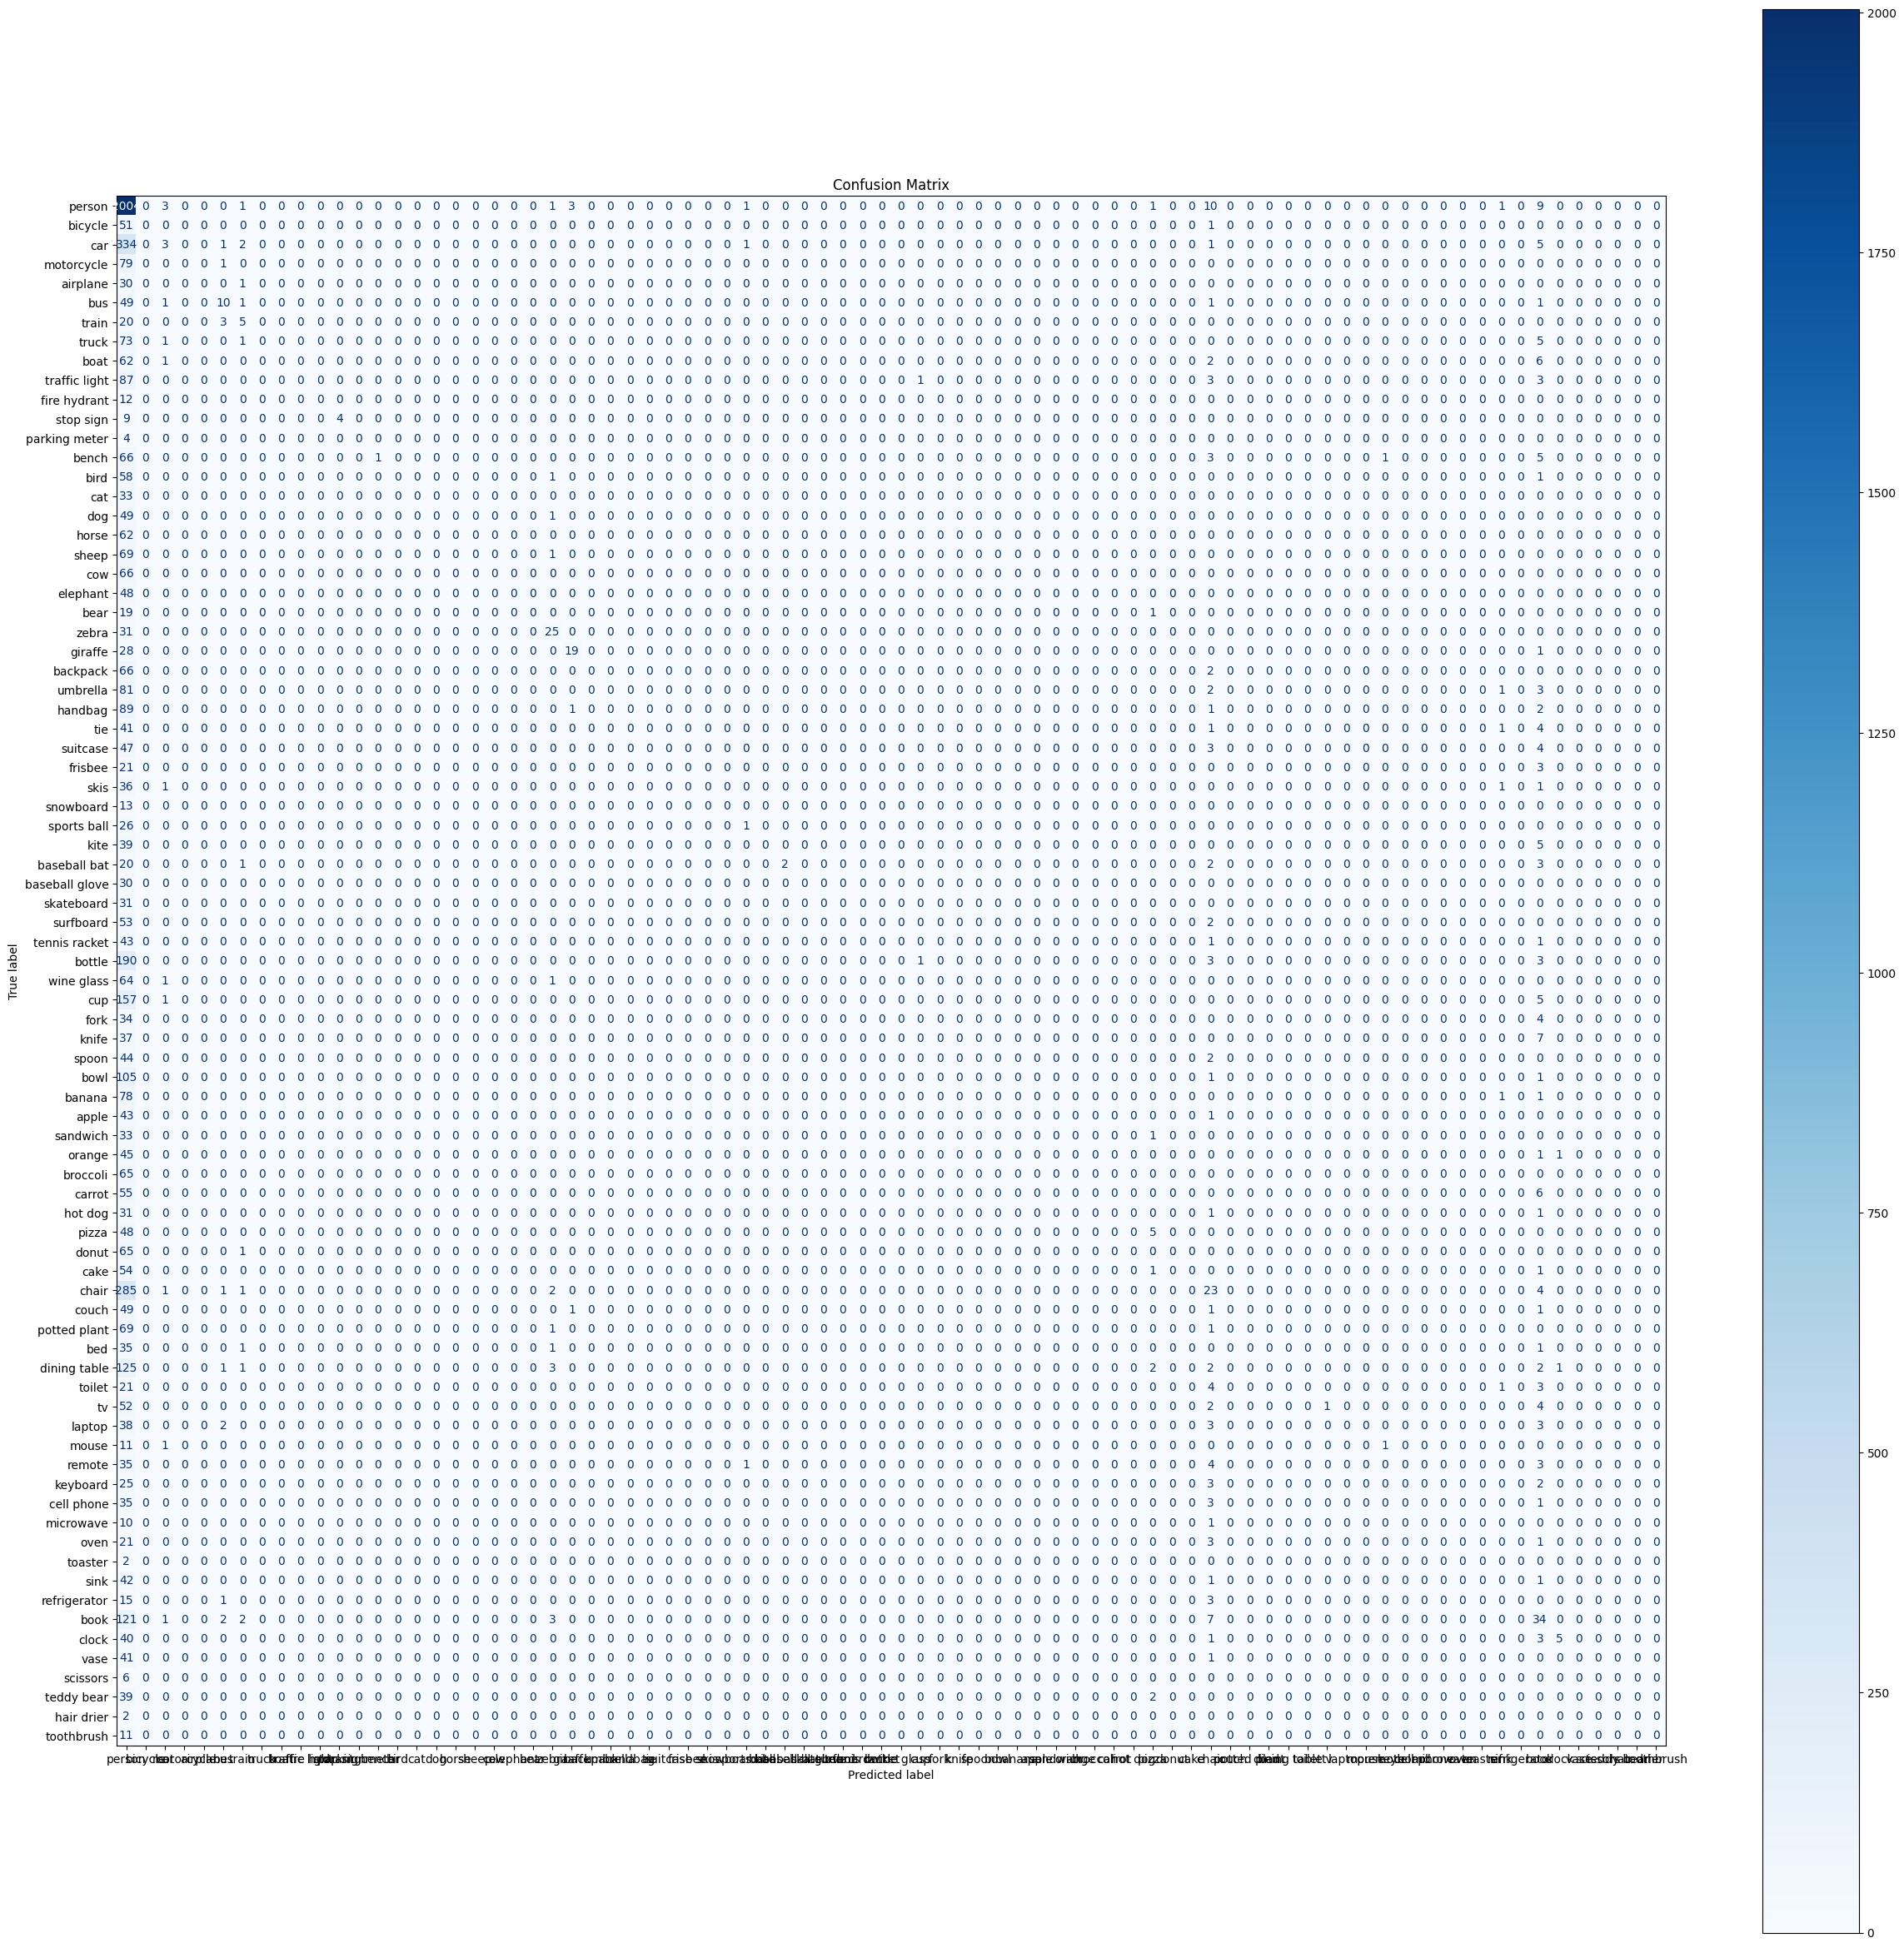

In [40]:
# plot confusion matrix

conf_matirx = confusion_matrix(y_test_filtered, y_pred)

from sklearn.metrics import ConfusionMatrixDisplay
cm_disp = ConfusionMatrixDisplay(confusion_matrix=conf_matirx, display_labels=target_names)

fig, ax = plt.subplots(figsize=(30,30))
ax.set_title('Confusion Matrix')
cm_disp.plot(ax=ax, cmap=plt.cm.Blues)

Visualization some of the prediction result

save the models

including the kmeans, tfidf and svm

In [41]:
# save the kmeans, tfidf and svm models

from joblib import dump

model_dir = Path('models/sift_based')
if not model_dir.exists():
    model_dir.mkdir(parents=True)

dump(kmeans, model_dir / 'kmeans.joblib')
dump(tfidf_transformer, model_dir / 'tfidf.joblib')
dump(svm, model_dir / 'svm.joblib')

['models/sift_based/svm.joblib']

In [42]:
# save both training and testing dataset

sift_dataset_training_filtered.save_to_disk(model_dir / 'sift_dataset_training')
sift_dataset_testing_filtered.save_to_disk(model_dir / 'sift_dataset_testing')

Saving the dataset (2/2 shards): 100%|██████████| 7357/7357 [00:01<00:00, 6936.40 examples/s]
